In [1]:
import copy
from functools import partial
from typing import *

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb
import wandb.apis

api = wandb.Api()

In [34]:
def load_one(run: wandb.apis.public.Run) -> Dict[str, Any]:
    if "count" in run.summary:
        task = run.config["task"]["name"]
        mc = run.summary["model_config"]
        score_key = dict(
            squad="match",
            squad_train="match",
            triviaqa="match",
            cnn_dailymail="rougeL",
            wikitext_bpc="bpc",
            repetition="match_length_char",
        )[task]
        sparsity = copy.deepcopy(run.config["sparsity"])
        assert sparsity.pop("score", None) in [None, "sparse_q"]
        scores = [r[score_key] for r in run.summary["results"]]
        return dict(
            task=task,
            confusion_contexts=run.config["task"].get("confusion_contexts"),
            model=run.config["model"].split("/")[1].replace("-hf", "").lower(),
            n_heads=mc["num_attention_heads"] * mc["num_hidden_layers"],
            head_size=mc["hidden_size"]//mc["num_attention_heads"],
            **sparsity,
            prefill_length=run.summary["prefill_length"],
            score=np.mean(scores),
            score_stderr=np.sqrt(np.var(scores) / len(scores)),
        )

def load_sweep(experiment_name: str, *single_runs: str) -> pd.DataFrame:
    return pd.DataFrame.from_dict(filter(None, (
        load_one(run)
        for run in api.runs(
            "research/sparse-attention", {"$or": [
                {"config.name": experiment_name},
                *({"display_name": n} for n in single_runs)
            ]}
        )
    )))

def memory_transfers_attention_only(s: pd.Series, count_kv: bool = True, count_index: bool = True) -> int:
    kv_elements, index_elements = 0, 0  # per-head
    if s["name"] == "dense":
        # write 1*(k, v) + read all prefill_length*(k, v)
        kv_elements = (2 + 2 * s["prefill_length"]) * s["head_size"]

    elif s["name"] == "sparse_v":
        # write 1*(k, v) + read all prefill_length*k + read sparse_k*v
        kv_elements = (2 + s["prefill_length"] + s["k"]) * s["head_size"]

    elif s["name"] == "local":
        # write 1*(k, v) + read sparse_k*v
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]

    elif s["name"] == "eviction":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write scores
        index_elements = (1 + 2 * s["prefill_length"])

    elif s["name"] == "ann":
        # write 1*(k, v) + read all sparse_k*(k, v)
        kv_elements = (2 + 2 * s["k"]) * s["head_size"]
        # read/write index
        index_elements = s["head_size"] + s["prefill_length"] * s["rank"]
        if s["reallocate_to_mean_value"]:
            index_elements += 2 * s["head_size"]

    else:
        assert False, s["name"]

    return (count_kv * kv_elements + count_index * index_elements) * s["n_heads"]

df = (
    pd.concat([load_sweep("RMOE-78-long-context-v0"), load_sweep("RMOE-78-long-context-v1")]).reset_index(drop=True)
    .pipe(lambda d: d.assign(transfers=d.apply(memory_transfers_attention_only, axis=1)))
    [["model", "confusion_contexts", "name", "k", "rank", "transfers", "prefill_length", "score", "score_stderr"]]
)
df.head()

,model,confusion_contexts,name,k,rank,transfers,prefill_length,score,score_stderr
0,vicuna-7b-v1.5-16k,7,eviction,2048.0,NaN,5.403905e+08,1590.032,0.638,0.021492
1,vicuna-7b-v1.5-16k,7,eviction,1024.0,NaN,2.719550e+08,1590.032,0.598,0.021927
2,vicuna-7b-v1.5-16k,7,eviction,512.0,NaN,1.377373e+08,1590.032,0.424,0.022101
3,vicuna-7b-v1.5-16k,7,eviction,256.0,NaN,7.062842e+07,1590.032,0.258,0.019567
4,vicuna-7b-v1.5-16k,7,eviction,128.0,NaN,3.707399e+07,1590.032,0.162,0.016478


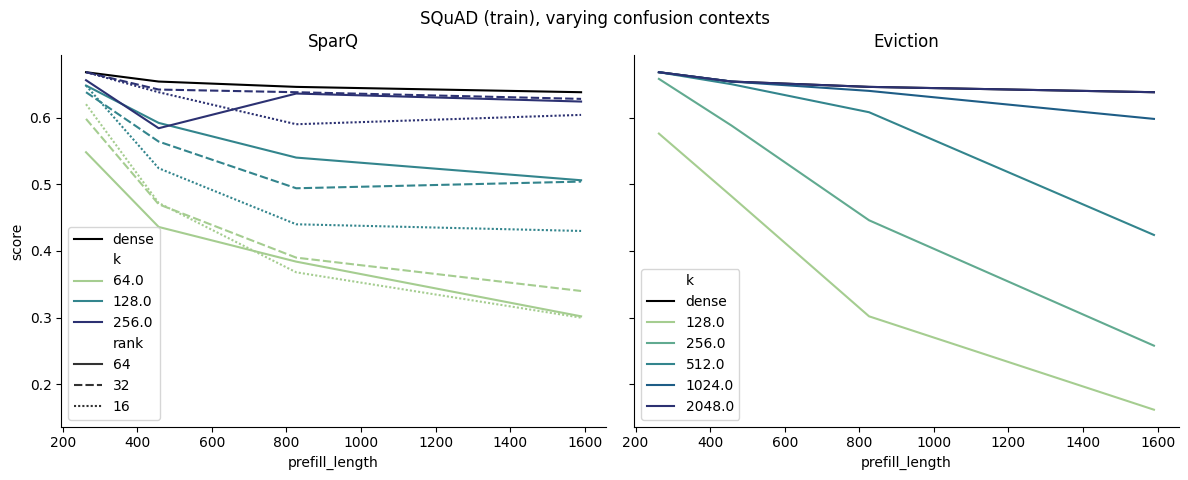

In [36]:
d = df[df.model == "vicuna-7b-v1.5-16k"]
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
sns.lineplot(data=d[d.name=="dense"], y="score", x="prefill_length", color="k", label="dense", ax=ax0)
sns.lineplot(data=d[d.name=="ann"], y="score", x="prefill_length", hue="k", hue_norm=matplotlib.colors.LogNorm(), style="rank", style_order=[64, 32, 16], palette="crest", ax=ax0)
sns.lineplot(data=d[d.name=="dense"], y="score", x="prefill_length", color="k", label="dense", ax=ax1)
sns.lineplot(data=d[d.name=="eviction"], y="score", x="prefill_length", hue="k", hue_norm=matplotlib.colors.LogNorm(), palette="crest", ax=ax1)
ax0.set_title("SparQ")
ax1.set_title("Eviction")
plt.suptitle("SQuAD (train), varying confusion contexts", y=0.95)
plt.tight_layout()
sns.despine()

In [66]:
df.groupby("confusion_contexts").prefill_length.mean()

confusion_contexts
0     262.542
1     457.322
3     826.104
7    1590.032
Name: prefill_length, dtype: float64

Text(0.5, 1.0, 'Score relative to dense')

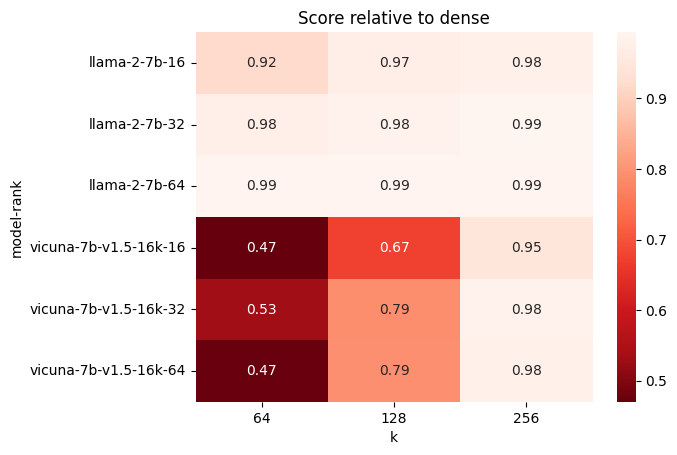

In [65]:
d = (df
    .pipe(lambda d: d[d.confusion_contexts == 7])
    .groupby("model").apply(lambda g: g.assign(score_ratio=g.score/g.score[g["name"]=="dense"].iloc[0])).reset_index(drop=True)
    .pipe(lambda d: d[d["name"] == "ann"])
    .pipe(lambda d: d.assign(rank=d["rank"].astype("int"), k=d["k"].astype("int")))
)
ax = sns.heatmap(d.pivot_table(index=["model", "rank"], columns="k", values="score_ratio"), annot=True, cmap="Reds_r")
ax.set_title("Score relative to dense")